In [1]:
from io import open
import glob
import os
import unicodedata
import string
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from IPython.display import HTML
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.regularizers import l2

### Load Data

In [3]:
# inspect the data directory
dpath = '../data/name_class/names/*.txt'
def findFiles(path): 
    return glob.glob(path)

print(findFiles(dpath))

['../data/name_class/names/Vietnamese.txt', '../data/name_class/names/German.txt', '../data/name_class/names/Scottish.txt', '../data/name_class/names/Spanish.txt', '../data/name_class/names/Italian.txt', '../data/name_class/names/Czech.txt', '../data/name_class/names/Greek.txt', '../data/name_class/names/Chinese.txt', '../data/name_class/names/Korean.txt', '../data/name_class/names/Irish.txt', '../data/name_class/names/Portuguese.txt', '../data/name_class/names/Dutch.txt', '../data/name_class/names/Russian.txt', '../data/name_class/names/English.txt', '../data/name_class/names/Polish.txt', '../data/name_class/names/French.txt', '../data/name_class/names/Arabic.txt', '../data/name_class/names/Japanese.txt']


In [4]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(categories=None):
    names_list = []
    for filename in findFiles('../data/name_class/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df
    

languages = ["English","French","Italian","German","Spanish"]
names = load_data(languages)
names.head()

,name,lang
0,Abbing,German
1,Abel,German
2,Abeln,German
3,Abt,German
4,Achilles,German


In [5]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)
names.groupby('lang')['name'].count()

Maximum name length:  18


lang
English    3668
French      277
German      724
Italian     709
Spanish     298
Name: name, dtype: int64

### Alphabet

Extract from the list of names all the characters occurring. This gives the basis for constructing a vector space representation of the characters by one-hot-vectors.

Foresee a suitable character for the end of the word, e.g. 'END'.

In [20]:
names

,name,lang
0,Abbing,German
1,Abel,German
2,Abeln,German
3,Abt,German
4,Achilles,German
...,...,...
5671,Villeneuve,French
5672,Vincent,French
5673,Vipond,French
5674,Voclain,French


In [24]:
### START YOUR CODE

alphabet = list(set([char for word in names.name.values for char in word]))
alphabet.append('END')

### END YOUR CODE
alphabet.append('-') # added for later purpose
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  75
['ñ', 'y', 'S', 'ü', 'ä', 'ì', 'D', 'W', 'ù', 'z', 'R', 'J', 'F', 'Z', 'm', 'B', 'i', 'L', 'C', 'H', 'K', 'U', 'á', 'Y', 'N', 'A', ' ', 'g', 'f', 'V', 'w', 'r', 'a', 'd', 't', 'T', 'G', 'b', 'I', 'ú', 'ò', 'ç', 'ß', 'h', 'x', 'à', 'o', 'n', 'c', 'E', 'l', 'e', 'k', 'ö', 'v', 'É', 'X', 'u', 'q', 'O', 'j', 'ê', 'p', 'Á', 'M', 'ó', 'Q', 'í', 's', 'é', 'P', 'è', "'", 'END', '-']


### Vector Representations

In [25]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

In [26]:
print(lang_representation("French",language_to_index))

[0. 0. 0. 0. 1.]


### Prepare train/test

In [27]:
msk = np.random.rand(len(names)) < 0.8
train = names[msk]
test = names[~msk]

In [28]:
X_train = []
Y_train = []
for name in train.name:
    X_train.append(name_representation(name,maxlen))
for lang in train.lang:
    Y_train.append(lang_representation(lang, language_to_index))

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
print(X_train.shape,Y_train.shape) 

(4491, 18, 75) (4491, 5)


In [29]:
X_test = []
Y_test = []
for name in test.name:
    X_test.append(name_representation(name,maxlen))
for lang in test.lang:
    Y_test.append(lang_representation(lang, language_to_index))
        
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_test.shape,Y_test.shape) 

(1185, 18, 75) (1185, 5)


### Utility

In [30]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (max):', acc[-1])
    print('Train accuracy (end):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (end) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

### Define and Train the Model

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [35]:
X_train.shape

(4491, 18, 75)

In [83]:
### START YOUR CODE
### START YOUR CODE
n_languages = len(np.unique(names.lang))
n_hidden = 128
nepochs=20
model = Sequential([
    SimpleRNN(n_hidden, input_shape=(18, 75)),
    Dense(n_languages, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### END YOUR CODE
model.summary()
### END YOUR CODE

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 128)               26112     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 26,757
Trainable params: 26,757
Non-trainable params: 0
_________________________________________________________________


In [84]:
### START YOUR CODE
log = model.fit(X_train, Y_train, epochs=nepochs, validation_data=(X_test, Y_test))
### END YOUR CODE

Train on 4491 samples, validate on 1185 samples
Epoch 1/20
4491/4491 [==============================] - 2s 444us/sample - loss: 0.9954 - accuracy: 0.6589 - val_loss: 0.8379 - val_accuracy: 0.6954
Epoch 2/20
4491/4491 [==============================] - 1s 314us/sample - loss: 0.8089 - accuracy: 0.7136 - val_loss: 0.7623 - val_accuracy: 0.7257
Epoch 3/20
4491/4491 [==============================] - 1s 246us/sample - loss: 0.7368 - accuracy: 0.7339 - val_loss: 0.7664 - val_accuracy: 0.7300
Epoch 4/20
4491/4491 [==============================] - 1s 244us/sample - loss: 0.6871 - accuracy: 0.7522 - val_loss: 0.7413 - val_accuracy: 0.7241
Epoch 5/20
4491/4491 [==============================] - 1s 243us/sample - loss: 0.6675 - accuracy: 0.7640 - val_loss: 0.7210 - val_accuracy: 0.7316
Epoch 6/20
4491/4491 [==============================] - 1s 245us/sample - loss: 0.6390 - accuracy: 0.7733 - val_loss: 0.6723 - val_accuracy: 0.7536
Epoch 7/20
4491/4491 [==============================] - 1s 246us

Train accuracy (max): 0.88777554
Train accuracy (end): 0.88777554
Test accuracy (end) : 0.7611814
Test accuracy (end) : 0.77299577


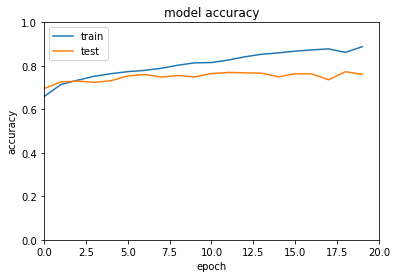

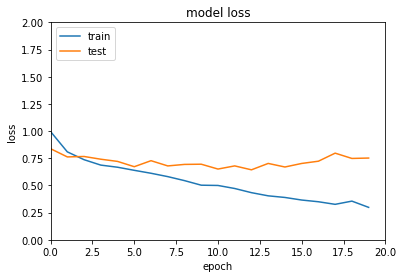

In [85]:
performance_plots(model, X_test, Y_test, log, nepochs)

### Confusion matrix

Compute the confusion matrix and jduge for which languages the names are hard to classify. 

In [86]:
### START YOUR CODE
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(Y_test, axis=1), y_pred)
### END YOUR CODE
print(cm)

[[ 89   5   3  74   5]
 [  5  20  15   7   2]
 [  4  12 103  27   3]
 [ 30  17  20 682  14]
 [  6   2   4  28   8]]


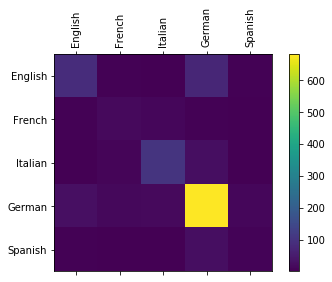

In [88]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()